In [4]:
import tensorflow as tf
import numpy as np
import random
configure_gpu_options()
print(tf.config.list_physical_devices('GPU'))

from os import listdir

def configure_gpu_options():
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.compat.v1.Session(config=config)
    tf.compat.v1.keras.backend.set_session(sess)

In [5]:
from os import path
from pydub import AudioSegment


def transform_to_wav(filepaths, directory_name):
    for path in filepaths:
        # files

        dst = path.replace(directory_name, directory_name + "_mono_wav").replace("mp3","wav")

        # convert wav to mp3                                             
        sound = AudioSegment.from_mp3(path)
        l = sound.split_to_mono()
        sound = l[np.random.randint(0,2)] # randomly take first or second channel
        sound = sound.set_frame_rate(1000)
        sound.export(dst, format="wav")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
!cd /content/drive/MyDrive/MusicGenreClassification

In [ ]:
paths = listdir("/content/drive/MyDrive/MusicGenreClassification")

paths = ["/content/drive/MyDrive/MusicGenreClassification/" + p for p in paths]

In [ ]:
"""all_mp3 = []
for path in paths:
    files = listdir(path)
    for file in files:
        all_mp3.append(path + file)
print(len(all_mp3))

filepaths = all_mp3"""

In [ ]:
# check for broken/corrupted audio files

for file in filepaths:
    try:
        a = tf.io.read_file(file)
        a,sr = tf.audio.decode_wav(a, desired_samples = 22050*30 )
        b = tfio.audio.resample(a,22050, 4000)

    except:
        print(file)

In [ ]:
def decode_audio(audio_binary, original_sr, desired_sr, duration):
    """decodes wav file and applies sub- or supersampling to achieve a desired sampling rate"""
    audio, _ = tf.audio.decode_wav(audio_binary, desired_samples = duration * original_sr)
    audio = tfio.audio.resample(audio, original_sr, desired_sr)
    return tf.squeeze(audio, axis=-1), desired_sr

# get filenames
#filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')

def data_generator():
    """
    Relies on a global argument dictionary

    T: number of time-steps to use for the context embedding c_t

    k: number of future time-steps to predict

    N: number of samples (1 positive + N-1 negative samples)

    window_duration: window duration in seconds

    original_sr: sampling rate of original audio files

    desired_sr: sampling rate as input to CPC (used for subsampling)

    duration: assumed full duration of an audio file (30s, files get truncated or padded with zeros)

    filepaths: list of all filepaths to all audio files
    """
    global data_generator_arguments
    T = data_generator_arguments["T"]
    k = data_generator_arguments["k"]
    N = data_generator_arguments["N"]
    window_duration = data_generator_arguments["window_duration"]
    original_sr = data_generator_arguments["original_sr"]
    desired_sr = data_generator_arguments["desired_sr"]
    duration = data_generator_arguments["full_duration"]
    filepaths = data_generator_arguments["filepaths"]

    while True: 

        #randomly select sample filepaths from list for N samples
        samples = random.sample(filepaths, N)
        positive_sample = samples[0]
        negative_samples = samples[1:]

        # take full 30 seconds of positive sample
        positive_audio = tf.io.read_file(positive_sample)
        positive_audio, sample_rate = decode_audio(positive_audio, original_sr, 
                                                   desired_sr, duration)

        window_size = int(sample_rate * window_duration)
        positive_audio = tf.reshape(positive_audio, (T+k, window_size, 1))

        # negative samples (find a way to do it without a for loop pls)
        sample_tensors = []
        sample_tensors.append(positive_audio)

        for ns in negative_samples:
            ns = tf.io.read_file(ns)
            ns, sample_rate = decode_audio(ns, original_sr,
                                           desired_sr, duration)

            # cut to 30s
            window_size = int(sample_rate * window_duration)

            ns = tf.reshape(ns, (T+k,window_size,1))

            # only take the last k entries (better: a random part of the audio)
            ns = ns[T:T+k]

            sample_tensors.append(ns)

        # concatenate all tensors, making its shape (T+k*N, window_size,1)
        data = tf.concat(sample_tensors, axis= 0)

        yield data

In [ ]:
files = listdir("/content/drive/MyDrive/MusicGenreClassification")

filepaths = ["/content/drive/MyDrive/MusicGenreClassification/" + f for f in files]



data_generator_arguments = {
    "T" : 20,
    "k" : 10,
    "N" : 8,
    "window_duration" : 1,
    "full_duration" : 30,
    "original_sr" : 22050,
    "desired_sr" : 4000,
    "filepaths" : filepaths
    }

DataGen = data_generator()

print(next(DataGen).shape)

(100, 4000, 1)


In [ ]:
T = data_generator_arguments["T"]
k = data_generator_arguments["k"]
N = data_generator_arguments["N"]
sampling_rate = data_generator_arguments["desired_sr"]
window_duration = data_generator_arguments["window_duration"]
batch_size = 8


data_shape = (T+k*N, sampling_rate * window_duration, 1)

train_ds = tf.data.Dataset.from_generator(generator = data_generator, 
                                    output_signature = tf.TensorSpec(data_shape, 
                                                                     dtype=tf.dtypes.float32, name=None)
                                    )

train_ds = train_ds.batch(batch_size)

In [ ]:
z_dim = 256  # latent dim z_t
c_dim = 512  # dim of g_ar output c_t

class Encoder (tf.keras.Model):
    '''
    g_enc: strided 1d convolution
    '''

    def __init__ (self, z_dim):
        super(Encoder, self).__init__()
        s = [5,4,2,2,2]  # stride sizes
        k = [10,8,4,4,4]  # kernel sizes
        f = [128,128,128,128,128]  # num filters

        # input dim: [batch, T+K*N, d, 1]
        self.enc_layers = []
        for l in range(5):
            self.enc_layers.append(tf.keras.layers.Conv1D(f[l],k[l],s[l]))
            self.enc_layers.append(tf.keras.layers.BatchNormalization())
            self.enc_layers.append(tf.keras.layers.LeakyReLU())
        self.enc_layers.append(tf.keras.layers.GlobalAveragePooling1D())
        self.enc_layers.append(tf.keras.layers.Dense(z_dim, activation='tanh'))
        # ouput dim:[batch, T+K*N, z]
    @tf.function
    def call (self, x, training):
        
        for l in self.enc_layers:
            try:  # batch normalization 
                x = l(x, training)
            except:
                x = l(x)
        return x


class Autoregressive (tf.keras.Model):
    '''
    g_ar: GRU RNN
    '''

    def __init__ (self, c_dim):
        super(Autoregressive, self).__init__()
        # input dim: [batch, T, z]
        self.gru = tf.keras.layers.GRU(c_dim, name='ar_context') 
        # output dim:[batch, c] since return_seq is False
    @tf.function
    def call (self, z):
        return self.gru(z)


class Predict_z (tf.keras.layers.Layer):
    '''
    transformation of c_t, currently linear (W_k) for all future timesteps
    '''

    def __init__ (self, z_dim, K):
        super(Predict_z, self).__init__()
        
        # input_dim: [batch, c]
        self.transform_layers = []
        for k in range(K):  # k different layers for each timestep
            self.transform_layers.append(tf.keras.layers.Dense(z_dim)) 
    #@tf.function
    def call(self, c_t):
        # TODO: maybe size should be multidimensional
        z_pred = tf.TensorArray(tf.float32, size=len(self.transform_layers))
        for l in tf.range(len(self.transform_layers)):  
            z_pred = z_pred.write(l, self.transform_layers[l](c_t))  # apply for each k
            z_pred_t = z_pred.stack()
            # [K, batch, z]
        return tf.transpose(z_pred_t, perm=[1,0,2])  # output_dim: [batch, K, z]

#@tf.function
def compute_f (z, z_pred):
    '''
    compute f following eq(3) in the paper to be batch (K x N) matrices.
    First column is the postive sample.
    '''

    # z input dim: [batch, K, N, z], 
    z = tf.expand_dims(z, axis=-2)  # [batch, K, N, 1, z]
    
    # z_pred input dim: [batch, K, z]
    pred = tf.repeat(z_pred, repeats=z.shape[2], axis=-2)  # [batch, K*N, z]
    pred = tf.reshape(pred, shape=[z.shape[0],z.shape[1],z.shape[2],z.shape[-1]])  # [batch, K, N, z]
    pred = tf.expand_dims(pred, axis=-1)  # [batch, K, N, z, 1]

    dot_prod = tf.linalg.matmul(z, pred)  # [batch, K, N, 1, 1]
    dot_prod = tf.squeeze(dot_prod, axis=[-2,-1])  # [batch, K, N]
    dot_prod = tf.exp(dot_prod)
    return dot_prod  # output dim: [batch, K, N]


class CPC (tf.keras.models.Model):
    '''
    put everything together. Return f_k for every k
    '''

    def __init__ (self, num_time_observations, num_time_future, num_negative_samples, z_dim, c_dim):
        super(CPC, self).__init__()
        self.T = num_time_observations
        self.K = num_time_future
        self.N = num_negative_samples
        self.z = z_dim
        self.c = c_dim

        self.g_enc = Encoder(self.z)
        self.g_ar = Autoregressive(self.c)
        self.p_z = Predict_z(z_dim=self.z, K=self.K)
    #@tf.function
    def call(self, x, training=False):  
        # input dim: [batch, T+K*N, d, 1]
        #print('input dim: ', x.shape)
        # Embedding
        z_t = tf.keras.layers.TimeDistributed( # dim 1 is the temporal dim 
            self.g_enc)(x, training=training)  # [batch, T+K*N, z]
        #print('embedding dim: ', z_t.shape)    
        

        # Split current observation embeddings and future embeddings
        z_obs = z_t[:, :self.T]  # t = {0,...,T}, dim: [batch, T, z]
        z_future = z_t[:, self.T:]  # t = {T+1,,,T+K} for N samples, dim:[batch, K*N, z]
        z_future = tf.reshape(z_future, [-1, self.K, self.N, self.z])  # [batch, K, N, z]
        #print('embedding obs:', z_obs.shape)
        #print('embedding pred:', z_future.shape)

        # Predict embeddings
        c_T = self.g_ar(z_obs)  # [batch, c]
        #print('context:', c_T.shape)
        z_pred = self.p_z(c_T)  # [batch, K, z]
        #print('transformed_context:', z_pred.shape)

        # Compute f matrices
        f_mat = compute_f(z_future, z_pred)  # [batch, K, N]

        return f_mat



cpc = CPC(T, k, N, z_dim, c_dim)

In [ ]:
class InfoNCE (tf.keras.losses.Loss):
    '''
    Compute loss given batch times f matrices with dim (K x N)
    '''

    def __call__(self, f):
        # input dim: [batch, K, N]
        denominator = tf.reduce_sum(f, axis=2)  # [batch, K]
        losses = - tf.math.log(f[:,:,0] / denominator)  # first column is positive
        return tf.reduce_mean(tf.reduce_mean(losses, axis=1),axis=-1)  # [batch]. Take a mean over k timesteps

In [ ]:
loss = InfoNCE()

In [ ]:
for i in train_ds.take(1):
    nce_loss = loss(cpc(i))

In [ ]:
tf.print(nce_loss)

2.07944274


In [ ]:
#@tf.function
def train_step(model, ds, loss_function, optimizer, 
               steps_per_epoch, train_loss_metric=None, 
               train_acc_metric= None):
    '''
    Training for one epoch.
    '''

    for batch in ds.take(steps_per_epoch): # use 100 batch per epoch
        # forward pass with GradientTape
        with tf.GradientTape() as tape:
            prediction = model(batch)
            loss = loss_function(prediction)

        # backward pass via GradienTape (auto-gradient calc)
        if not tf.math.is_nan(loss):
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            # update metrics
            if train_loss_metric is not None:
                train_loss_metric.update_state(loss)
            if train_acc_metric is not None:
                train_acc_metric.update_state(target, prediction)
        else:
            tf.print("loss is nan, no parameters updated")
            tf.print("f_matrix:", prediction)


        

In [ ]:
epochs = 100
train_loss_metric = tf.keras.metrics.Mean('train_loss')
optimizer = tf.keras.optimizers.Adam(3e-5)

for e in range(epochs):
    train_step(cpc, train_ds, loss, optimizer, 1, train_loss_metric)

    if e%10 == 0:
        print(train_loss_metric.result().numpy())
        train_loss_metric.reset_states()

loss is nan, no parameters updated
0.0


KeyboardInterrupt: ignored

In [ ]:
cpc.variables

[<tf.Variable 'conv1d_30/kernel:0' shape=(10, 1, 128) dtype=float32, numpy=
 array([[[nan, nan, nan, ..., nan, nan, nan]],
 
        [[nan, nan, nan, ..., nan, nan, nan]],
 
        [[nan, nan, nan, ..., nan, nan, nan]],
 
        ...,
 
        [[nan, nan, nan, ..., nan, nan, nan]],
 
        [[nan, nan, nan, ..., nan, nan, nan]],
 
        [[nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)>,
 <tf.Variable 'conv1d_30/bias:0' shape=(128,) dtype=float32, numpy=
 array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, na

In [ ]:
# get all filenames
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')

# split filenames into test, train and val set
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

# load audio
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

#get label for filepath
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2]

# get both waveform and label for a filepath
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

# make a tf dataset for the train files
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

# get spectrogram for audio file
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)

  spectrogram = tf.abs(spectrogram)

  return spectrogram

# plot spectrogram and waveform for audio file
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
# show audio file in notebook
display.display(display.Audio(waveform, rate=16000))


def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  X = np.arange(16000, step=height + 1)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()



# turn waveform dataset into spectrogram dataset

def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

# combine preprocessing into one function from files to spectrogram dataset
def preprocess_dataset(files, spectrogram=False):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

  if spectrogram:
    output_ds = output_ds.map(
        get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
    
  return output_ds

# preprocess data
train_ds = preprocess_dataset(train_files)
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)


# plot a confusion matrix for the predictions/classifications

test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
# Sampling rate: 22.050 instead of 16000, 16bit mono wav

# multiply audio waveform by tf.signal.hamming_window(window_size)

# use a 5 second window. window_size =  5 * sampling_rate

# randomly choose positive sample (1 or multiple?) from all filenames (then choose a 5 second window randomly from the 30s song)

# randomly choose N-1 negative samples (also 5 second window) from all other files

In [ ]:
# Model (output of call function is the InfoNCE loss)

class CPC(tf.keras.Model):
    def __init__(self, k_steps):
        super(CPC,self).__init__()

        # number of timesteps to predict
        self.k_steps = k_steps

        # encoder: transforms windows of the audio into embeddings up to z_t
        self.g_enc = Encoder()

        # autoregressive model: predicts c_t based on z_t of the past k-steps into the future
        self.g_ar = AutoRegressive()

        # k times W for each z_t prediction
        self.linear_projections = [tf.keras.layers.Dense(output_size) for i in tf.range(k_steps)]

    def call(self, X):

        # process every window in X to get an embedding c_t (for positive and for negative samples)
        pass

        # process every embedding c_t with g_ar to calculate all z_t+k


### f score calculation
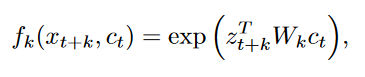


### f score meaning

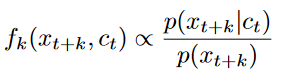



### maximizing correct f score vs incorrect f scores means maximizing mutual information between z_tk and c_t

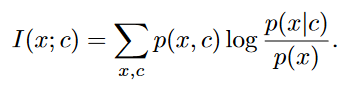


### InfoNCE loss: maximize mutual information between correct future timestep encoding and past context and minimize mutual information between false future timestep encoding and past context

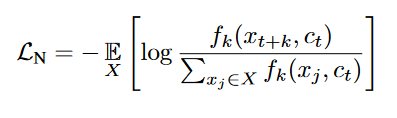